In [35]:
%load_ext autoreload
%autoreload 2
import html_parser
import ner
import psycopg2
import pandas as pd
import glob
from tqdm import tqdm
from names_parser import NameParser
import db

tqdm.pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from collections import Counter
import matplotlib.pyplot as plt

In [37]:
docs, cols = db.fetch_228(limit=1000000)
print("Total docs: ", len(docs), "attributes: ", cols)

Total docs:  499718 attributes:  ['encode', 'case_document_articles', 'case_common_document_type', 'case_court_type', 'u_common_case_defendant_m', 'case_year_result']


In [38]:
# Дропаем не приговоры, извлекаем год
df = pd.DataFrame(docs, columns=cols)
df["case_year_result"] = df["case_year_result"].apply(lambda x: str(int(x)))
df.drop(
    labels=df[~df["case_common_document_type"].isin(
        ['Приговор', 'Приговоры', 'Постановление', 'Постановления']
        )].index,
    inplace=True
    )
print(len(df))

360177


In [40]:
# Проверяем наличие извлеченных из html тексты на диске
df['text_count'] = df['encode'].progress_apply(db.find_texts)
df['text_count'].value_counts()

100%|██████████| 360177/360177 [01:40<00:00, 3595.08it/s]


1    260889
0     99288
Name: text_count, dtype: int64

In [11]:
import re
import itertools

def extract_articles(case_document_articles_record: str):
    parts = case_document_articles_record[2:-2].split('", "')
    # DIfferent Split cases
    parts = list(itertools.chain(*[p.split("] [") for p in parts]))
    parts = list(itertools.chain(*[p.split("; ") for p in parts]))
    parts = [p.replace(". ", ".").replace(" - ", ", ").replace("[", "").replace("]", "").replace("-", ", ") for p in parts]
    return parts

test_string = '["Статья 228.1 Часть 4 п.г; Статья 30 Часть 1 - Статья 228.1 Часть 4 п. а, Статья 30 Часть 3 - Статья 228.1 Часть 4 пп. \'а,б\' - Статья 228.1 Часть 4 пп. а, б - [Статья 188 Часть 2] [Статья 228.1 Часть 2 п. б]"]'
test_string_2 = '["Статья 69 Часть 3", "Статья 228 Часть 2", "Статья 228.1 Часть 1", "Статья 30 Часть 3 - Статья 229.1 Часть 1"]'
# print("3: ", extract_arcticles_3(test_string))
extract_articles(test_string_2)

['Статья 69 Часть 3',
 'Статья 228 Часть 2',
 'Статья 228.1 Часть 1',
 'Статья 30 Часть 3, Статья 229.1 Часть 1']

In [56]:
test_string_3 = '["Статья 228 Часть 2; Статья 228.1 Часть 2 п.б; Статья 228.1 Часть 4 п.г", "Статья 228 Часть 2; Статья 33 Часть 5-Статья 228 Часть 2"]'
extract_articles(test_string_3)

['Статья 228 Часть 2',
 'Статья 228.1 Часть 2 п.б',
 'Статья 228.1 Часть 4 п.г',
 'Статья 228 Часть 2',
 'Статья 33 Часть 5, Статья 228 Часть 2']

In [48]:
df["article_extracted"] = df["case_document_articles"].progress_apply(extract_articles)

100%|██████████| 360177/360177 [00:02<00:00, 153227.70it/s]


In [49]:
df.head(2)

,encode,case_document_articles,case_common_document_type,case_court_type,u_common_case_defendant_m,case_year_result,text_count,article_extracted
0,b09185e330815b9f0c858b33cf19ac5f,"[""Статья 228 Часть 1""]",Приговор,"Районный, городской, межрайонный суд",Габдуллин Р.Ф.. ... .01.09.2015. ... .ст.2...,2015,0,[Статья 228 Часть 1]
1,8fcf5eb65bc203197f1bbef69ecfe732,"[""Статья 30 Часть 1, Статья 228.1 Часть 4 п.г""]",Приговор,"Районный, городской, межрайонный суд",Пятков П.А.. ... .01.09.2015. ... .ст. 30 ...,2015,0,"[Статья 30 Часть 1, Статья 228.1 Часть 4 п.г]"


In [57]:
df['article_extracted'].value_counts()[:200].to_excel("articles_top200.xlsx", sheet_name='Sheet_name_1', engine='xlsxwriter')

In [51]:
df[["encode", "case_document_articles", "article_extracted"]].head()


,encode,case_document_articles,article_extracted
0,b09185e330815b9f0c858b33cf19ac5f,"[""Статья 228 Часть 1""]",[Статья 228 Часть 1]
1,8fcf5eb65bc203197f1bbef69ecfe732,"[""Статья 30 Часть 1, Статья 228.1 Часть 4 п.г""]","[Статья 30 Часть 1, Статья 228.1 Часть 4 п.г]"
2,282ee939b68435c5897a71848d62cf8c,"[""Статья 228 Часть 2"", ""Статья 33 Часть 5-Стат...","[Статья 228 Часть 2, Статья 33 Часть 5, Статья..."
3,581065d33d146b97fcd3fc3a7d9d2832,"[""Статья 30 Часть 1, Статья 228.1 Часть 4 п.г""]","[Статья 30 Часть 1, Статья 228.1 Часть 4 п.г]"
4,e23a03b6faf9469383f4e47a00629734,"[""Статья 33 Часть 5-Статья 228 Часть 1""]","[Статья 33 Часть 5, Статья 228 Часть 1]"


In [52]:
df[["encode", "case_document_articles", "article_extracted"]].to_excel("articles_check.xlsx", sheet_name='Sheet_name_1', engine='xlsxwriter')

In [ ]:
print(len(df))
for i, row in df.iterrows():
    articles_string = row["case_document_articles"]
    if "Статья 228 Часть 2; Статья 228.1 Часть 2" in articles_string:
        print(articles_string)

In [13]:
import itertools

flat_list = list(itertools.chain(*results))
vocab = list(set(flat_list))
print(f"Items: {len(flat_list)}, unique: {len(vocab)}")

Items: 982087, unique: 2371


In [10]:
flat_list.count("Статья")

1

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
w = Counter(flat_list)
mc = w.most_common()[:-200-1:-1] 
mc

In [29]:
from matplotlib.pyplot import figure
import matplotlib

figure(figsize=(9, 7), dpi=80)
matplotlib.rcParams['figure.figsize'] = (12, 10)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

<Figure size 720x560 with 0 Axes>

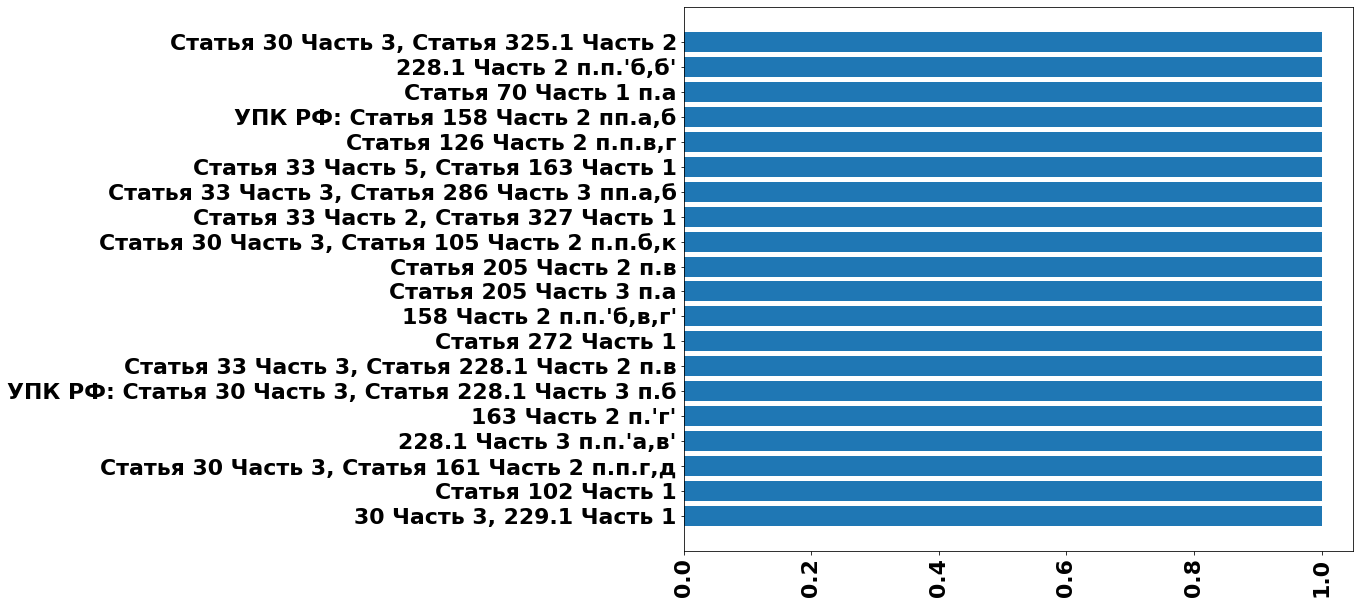

In [28]:
from collections import Counter
import matplotlib.pyplot as plt

w = Counter(flat_list).most_common()[:-20-1:-1] 
# plt.bar(w.keys(), w.values())
plt.barh([v[0] for v in w], [v[1] for v in w])
plt.xticks(rotation = 90);

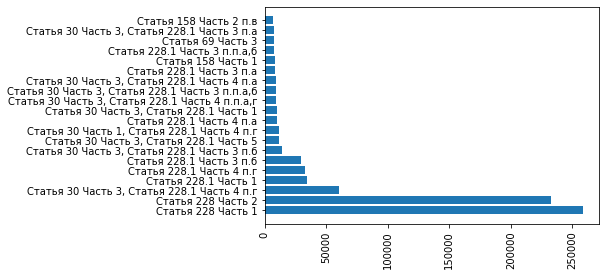

In [20]:
w = Counter(flat_list).most_common(20)
# plt.bar(w.keys(), w.values())
plt.barh([v[0] for v in w], [v[1] for v in w])
plt.xticks(rotation = 90);

In [ ]:
w = Counter(flat_list).most_common(200)
w

In [16]:
import pandas as pd
mc_df = pd.DataFrame(w, columns=["text", "count"])
mc_df.to_ex

,text,count
0,Статья 228 Часть 1,258899
1,Статья 228 Часть 2,232839
2,"Статья 30 Часть 3, Статья 228.1 Часть 4 п.г",60396
3,Статья 228.1 Часть 1,34713
4,Статья 228.1 Часть 4 п.г,32669
...,...,...
195,Статья 175 Часть 1,140
196,"Статья 30 Часть 1, Статья 228.1 Часть 2 пп.а,б",138
197,Статья 291.2 Часть 1,137
198,"Статья 228.1 Часть 2 п.п.а,б",136


In [18]:
!pip install xlsxwriter

  Using cached XlsxWriter-3.0.2-py3-none-any.whl (149 kB)


In [19]:
mc_df.to_excel("most_common_200_articles.xlsx", sheet_name='Sheet_name_1', engine='xlsxwriter')

# Clustering

In [32]:
counts = [flat_list.count(c) for c in vocab]

In [33]:
import math
math.sqrt(5621641)

2371.0

In [34]:
from tqdm.notebook import tqdm
import numpy as np
from sklearn.cluster import AffinityPropagation
import distance
import editdistance 

words = np.asarray(vocab) #So that indexing with a list will work
print("counting similarities...")
lev_distances = []
edit_distances = []
with tqdm(total=len(words)) as pbar:
    for i, w1 in enumerate(words):
        for w2 in words:
            d = editdistance.eval(w1, w2)
            d2 =  distance.levenshtein(w1,w2)
            edit_distances.append(d)
            lev_distances.append(d2)
        pbar.update(1)
        
# distances = [[distance.levenshtein(w1,w2) for w1 in words] for w2 in words]
edit_similarity = -1*np.array(edit_distances)
lev_similarity = -1*np.array(lev_distances)

counting similarities...


  0%|          | 0/2371 [00:00<?, ?it/s]

NameError: name 'lev_similarity' is not defined

In [36]:
affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
print("fitting...")
shape = math.sqrt(5621641)
affprop.fit(edit_similarity.reshape(int(shape), int(shape)))

fitting...


AffinityPropagation(affinity='precomputed')

In [37]:
import numpy as np
print(f"{len(np.unique(affprop.labels_))} Clusters...")

for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

94 Clusters...
 - *Статья 286 Часть 3 п.п.а,в:* Статья 126 Часть 3 п.п.а,в, Статья 126 Часть 3 пп.а,в, Статья 146 Часть 3 п.п.б,в, Статья 204 Часть 7 п.п.а,в, Статья 226 Часть 3 п.п.а,г, Статья 226 Часть 4 п.п.а,б, Статья 228 Часть 3 п.п.а,в, Статья 228 Часть 3 п.п.б,в, Статья 229 Часть 3 п.п.а,б, Статья 229 Часть 3 п.п.а,б,в,г, Статья 230 Часть 2 п.п.а,в, Статья 230 Часть 3 п.п.а,б, Статья 256 Часть 1 п.п.а,в, Статья 256 Часть 1 п.п.б,в, Статья 256 Часть 1 пп.б,в, Статья 264 Часть 6 п.п.а,б, Статья 286 Часть 3 п.п.а,б, Статья 286 Часть 3 п.п.а,б,в, Статья 286 Часть 3 п.п.а,в, Статья 286 Часть 3 п.п.б,в, Статья 286 Часть 3 пп.а,б, Статья 286 Часть 3 пп.а,б,в, Статья 286 Часть 3 пп.а,в, Статья 286 Часть 3 пп.б,в, Статья 290 Часть 5 п.п.а,в
 - *Статья 30 Часть 3, Статья 158 Часть 2 пп.б,в:* Статья 30 Часть 1, Статья 158 Часть 3 пп.а,в, Статья 30 Часть 3, Статья 105 Часть 2 пп.б,е, Статья 30 Часть 3, Статья 158 Часть 2 п.п.а,б,в, Статья 30 Часть 3, Статья 158 Часть 2 п.п.а,в, Статья 30 Ча

In [ ]:
import pandas as pd
import logging
logger = logging.getLogger()


df = pd.DataFrame(records)
df.head(2)